<a href="https://colab.research.google.com/github/GuruYohesh/Object-Detection/blob/main/Hippocampus__MaskRCNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Hippocampus in Brain
Hippocampus is a complex brain structure embedded deep into temporal lobe. It has a major role in learning and memory. The hippocampus is one of the regions that can be affected by the Alzheimer's disease, and this region is known to be related to memory loss. The structural changes of the hippocampus are important biomarkers for dementia. **To analyze the structural changes accurate localization plays a vital role.**
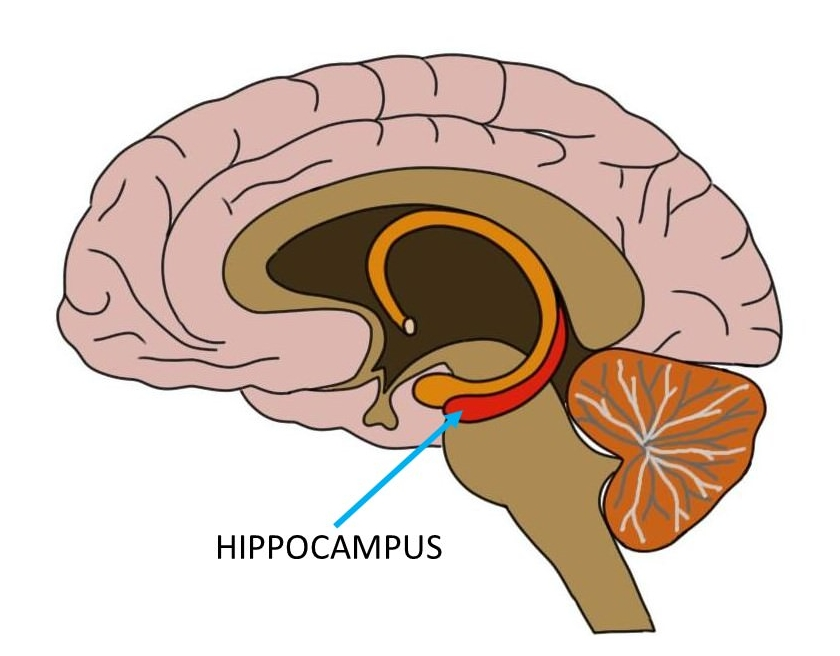

# Mask R-CNN
Mask R-CNN is a state of the art model for instance segmentation, developed on top of Faster R-CNN. Faster R-CNN is a region based convolutional neural network, that returns bounding boxes for each object in the image along with its class label and confidence score.
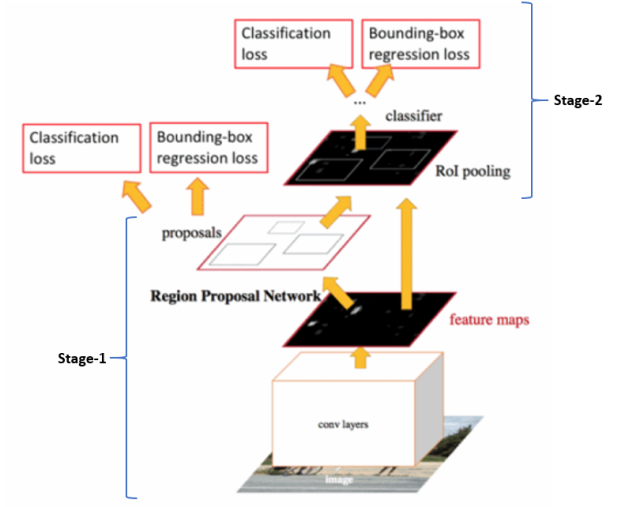

### Stage-1:
The first stage consists of two networks, backbone (ResNet, VGG, Inception, etc..) and region proposal network. These networks run once per image to give a set of region proposals. Region proposals are regions in the feature map which contain the object.
### Stage-2:
 In the second stage, the network predicts bounding boxes and object class for each of the proposed region obtained in stage1. Each proposed region can be of different size whereas fully connected layers in the networks always require fixed size vector to make predictions. Size of these proposed regions is fixed by using either RoI pool (which is very similar to MaxPooling) or RoIAlign method.
 
Faster R-CNN predicts object class and bounding boxes. Mask R-CNN is an extension of Faster R-CNN with additional branch for predicting segmentation masks on each Region of Interest (RoI).




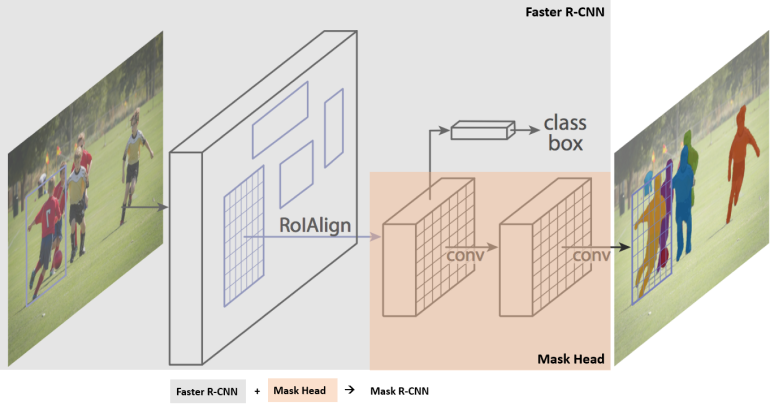


In the second stage of Faster R-CNN, RoI pool is replaced by RoIAlign which helps to preserve spatial information which gets misaligned in case of RoI pool. RoIAlign uses binary interpolation to create a feature map that is of fixed size for e.g. 7 x 7. The output from RoIAlign layer is then fed into Mask head, which consists of two convolution layers. It generates mask for each RoI, thus segmenting an image in pixel-to-pixel manner.

In [ ]:
# Your code here.
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# clone the Mask R-CNNN Repository
!git clone https://github.com/matterport/Mask_RCNN.git

Cloning into 'Mask_RCNN'...
remote: Enumerating objects: 956, done.
remote: Total 956 (delta 0), reused 0 (delta 0), pack-reused 956
Receiving objects: 100% (956/956), 125.23 MiB | 21.98 MiB/s, done.
Resolving deltas: 100% (560/560), done.


In [ ]:
# install specific version of tensorflow and keras
!sudo pip install --no-deps tensorflow==1.15.3
!sudo pip install --no-deps keras==2.2.4

     |████████████████████████████████| 110.5MB 95kB/s 
  Found existing installation: tensorflow 2.4.0
    Uninstalling tensorflow-2.4.0:
      Successfully uninstalled tensorflow-2.4.0
     |████████████████████████████████| 317kB 12.9MB/s 
  Found existing installation: Keras 2.4.3
    Uninstalling Keras-2.4.3:
      Successfully uninstalled Keras-2.4.3


In [ ]:
# install the Mask R-CNN Library
!pip install -r 'Mask_RCNN/requirements.txt'
!cd Mask_RCNN ; python setup.py install

     |████████████████████████████████| 3.8MB 12.3MB/s 
     |████████████████████████████████| 512kB 42.9MB/s 
     |████████████████████████████████| 51kB 6.9MB/s 
     |████████████████████████████████| 163kB 43.4MB/s 
     |████████████████████████████████| 204kB 50.3MB/s 
  Created wheel for gast: filename=gast-0.2.2-cp36-none-any.whl size=7540 sha256=ef8c8e1e22b20ce2023159d43ce9b3aca5797c225d5eab344dd07e3cb06962c6
  Stored in directory: /root/.cache/pip/wheels/5c/2e/7e/a1d4d4fcebe6c381f378ce7743a3ced3699feb89bcfbdadadd
Successfully built gast
ERROR: tensorflow-probability 0.12.1 has requirement gast>=0.3.2, but you'll have gast 0.2.2 which is incompatible.
  Found existing installation: tensorboard 2.4.0
    Uninstalling tensorboard-2.4.0:
      Successfully uninstalled tensorboard-2.4.0
  Found existing installation: gast 0.3.3
    Uninstalling gast-0.3.3:
      Successfully uninstalled gast-0.3.3
  Found existing installation: tensorflow-estimator 2.4.0
    Uninstalling tensorf

In [ ]:
# confirm the library was installed
!pip show mask-rcnn

Name: mask-rcnn
Version: 2.1
Summary: Mask R-CNN for object detection and instance segmentation
Home-page: https://github.com/matterport/Mask_RCNN
Author: Matterport
Author-email: waleed.abdulla@gmail.com
License: MIT
Location: /usr/local/lib/python3.6/dist-packages/mask_rcnn-2.1-py3.6.egg
Requires: 
Required-by: 


# Step -1: Build the custom hippocampus dataset.
Dataset class provides a consistent way to work with any dataset. Data class also supports loading multiple datasets at the same time.

In **load_dataset** method, we iterate through all the files in the train and test folder to add the class, images and annotations to create the dataset using add_class and add_image methods.

In **extract_boxes** method extracts each of the bounding box from the annotation file. Annotation files are XML files, it returns the box it's height and width.

In **load_mask** method generate masks for every object in the image. It returns one mask per instance and class ids, a 1D array of class id for the instance masks.

**image_reference** method returns the path of the image.

In [ ]:
# perform the necessary import
from os import listdir
from xml.etree import ElementTree
from numpy import zeros
from numpy import asarray
from mrcnn.utils import Dataset
import string
class hippocamp(Dataset):
  def load_dataset(self, directory):
    self.add_class("dataset",1,"hippocampus")
    for file in listdir(directory):
      if file.endswith('.jpg'):
        image_id = file[:-4]
        img_path = directory + file
        ann_path = directory + image_id + '.xml'
        self.add_image('dataset', image_id = image_id, path = img_path, annotation = ann_path)
  
  def extract_boxes(self, filename):
    # load and parse the file
    tree = ElementTree.parse(filename)
    # get the root of the document
    root = tree.getroot()
    # extract each bounding box
    boxes = []
    for box in root.findall('.//bndbox'):
      xmin = int(box.find('xmin').text)
      ymin = int(box.find('ymin').text)
      xmax = int(box.find('xmax').text)
      ymax = int(box.find('ymax').text)
      boxes.append([xmin, ymin, xmax, ymax])
    # extract image dimensions
    width = int(root.find('.//size/width').text)
    height = int(root.find('.//size/height').text)
    return boxes, width, height
  # load the masks for an image
  def load_mask(self, image_id):
    # get details of image
    info = self.image_info[image_id]
    # define box location
    path = info['annotation']
    # load XML
    boxes, w, h = self.extract_boxes(path)
    # create one array for all masks each on a different channel
    masks = zeros([h, w, len(boxes)], dtype = 'uint8')
    # ceate masks
    class_ids = []
    for i in range(len(boxes)):
      box = boxes[i]
      row_s, row_e = box[1], box[3]
      col_s, col_e = box[0], box[2]
      masks[row_s:row_e, col_s:col_e, i] = 1
      class_ids.append(self.class_names.index('hippocampus'))
    return masks, asarray(class_ids, dtype='int32')
  # load an image reference
  def image_reference(self, image_id):
    info = self.image_info[image_id]
    return info['path'] 

# Step-2: Prepare train and test

In [ ]:
#Prepare training set
training = hippocamp()
training.load_dataset(directory='/content/drive/MyDrive/images/images/train/')
training.prepare()
print('Total images in train: %d' % len(training.image_ids))

Total images in train: 98


In [ ]:
# prepare test set
test = hippocamp()
test.load_dataset(directory = '/content/drive/MyDrive/images/images/test/')
test.prepare()
print('Total images in test: %d' %len(test.image_ids))

Total images in test: 12


In [ ]:
image_id = 1
image = training.load_image(image_id)
print(image.shape)

(578, 828, 3)


In [ ]:
mask, class_ids = training.load_mask(image_id)
print(mask.shape)

(578, 828, 1)


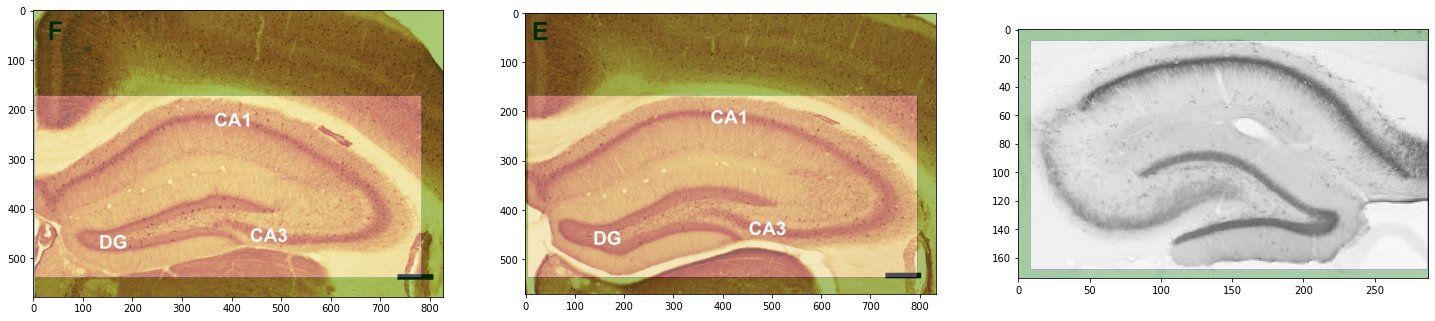

In [ ]:
import matplotlib.pyplot as plt
# plot first few images
plt.figure(figsize=(25,25))
for i in range(1,4):
  plt.subplot(1,3,i)
  image = training.load_image(i)
  plt.imshow(image)
  mask, _ = training.load_mask(i)
  for j in range(mask.shape[2]):
    plt.imshow(mask[:,:,j], cmap = 'ocean',alpha = 0.3)
plt.show()

Images showing location of hippocampus in train set images.

In [ ]:
# perform the necessary imports
from mrcnn.config import Config
from mrcnn.model import MaskRCNN

Using TensorFlow backend.


# Step - 3: Create hippocampConfig class
we create a hippocampConfig class for training on the hippocampus dataset. It is derived form the Mask R-CNN Config class and overrides some values.

In [ ]:
class hippocampConfig(Config):
  # define the name of the configuration
  NAME = "hippocampus_cfg"
  # number of classes
  NUM_CLASSES = 1 + 1
  # number of training steps per epoch
  STEPS_PER_EPOCH = 98
  #simplify GPU_config
  GPU_COUNT =1
  IMAGES_PER_GPU = 1

# Step-4 : create an instance of the hippocampConfig class

In [ ]:
#prepare config
cfg = hippocampConfig()
cfg.display()


Configurations:
BACKBONE                       resnet101
BACKBONE_STRIDES               [4, 8, 16, 32, 64]
BATCH_SIZE                     1
BBOX_STD_DEV                   [0.1 0.1 0.2 0.2]
COMPUTE_BACKBONE_SHAPE         None
DETECTION_MAX_INSTANCES        100
DETECTION_MIN_CONFIDENCE       0.7
DETECTION_NMS_THRESHOLD        0.3
FPN_CLASSIF_FC_LAYERS_SIZE     1024
GPU_COUNT                      1
GRADIENT_CLIP_NORM             5.0
IMAGES_PER_GPU                 1
IMAGE_CHANNEL_COUNT            3
IMAGE_MAX_DIM                  1024
IMAGE_META_SIZE                14
IMAGE_MIN_DIM                  800
IMAGE_MIN_SCALE                0
IMAGE_RESIZE_MODE              square
IMAGE_SHAPE                    [1024 1024    3]
LEARNING_MOMENTUM              0.9
LEARNING_RATE                  0.001
LOSS_WEIGHTS                   {'rpn_class_loss': 1.0, 'rpn_bbox_loss': 1.0, 'mrcnn_class_loss': 1.0, 'mrcnn_bbox_loss': 1.0, 'mrcnn_mask_loss': 1.0}
MASK_POOL_SIZE                 14
MASK_SHAPE         

# Step-5: Training
we initialize Mask R-CNN model for training using the config instance that we created. Then we load the pre-trained weights for the Mask R-CNN from COCO dataset excluding the last few layers.

We can increase the speed of learning for head layers by increasing the learning rate. I have used only 3 epochs as I trained it on a CPU.

In [ ]:
from mrcnn.model import MaskRCNN
from mrcnn import model as modellib
from mrcnn.model import log
import mrcnn
# define the model
model = MaskRCNN(mode='training',config = cfg,model_dir='./')
#load weights (mscoco) and exclude the ouput layers
model.load_weights('/content/drive/MyDrive/Colab Notebooks/Mask_RCNN/mask_rcnn_coco.h5', by_name = True,exclude = ['mrcnn_class_logits','mrcnn_bbox_fc','mrcnn_bbox','mrcnn_mask'])
# train weights (ouput layers or heads)
model.train(training, test, learning_rate =2* cfg.LEARNING_RATE, epochs = 3, layers  = 'heads')







Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


Instructions for updating:
box_ind is deprecated, use box_indices instead







Starting at epoch 0. LR=0.002

Checkpoint Path: ./hippocampus_cfg20210113T0242/mask_rcnn_hippocampus_cfg_{epoch:04d}.h5
Selecting layers to train
fpn_c5p5               (Conv2D)
fpn_c4p4               (Conv2D)
fpn_c3p3               (Conv2D)
fpn_c2p2               (Conv2D)
fpn_p5                 (Conv2D)
fpn_p2                 (Conv2D)
fpn_p3                 (Conv2D)
fpn_p4                 (Conv2D)
In model:  rpn_model
    rpn_conv_shared        (Conv2D)
    rpn_class_raw          (Conv2D)
    rpn_bbox_pred          (Conv2D)
mrcnn_mask_conv1       (TimeDistributed)
mrcnn_mask_bn1         (TimeDistributed)
mrcnn_mask_conv2       (TimeDistributed)
mrcnn_mask_bn2         (TimeDistributed)
mrcnn_class_conv1      (TimeDistributed)
mrcnn_class_bn1        (TimeDistributed)
mrcnn_mask_conv3       (TimeDistributed)

/usr/local/lib/python3.6/dist-packages/tensorflow_core/python/framework/indexed_slices.py:424: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "
/usr/local/lib/python3.6/dist-packages/tensorflow_core/python/framework/indexed_slices.py:424: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "
/usr/local/lib/python3.6/dist-packages/tensorflow_core/python/framework/indexed_slices.py:424: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


/usr/local/lib/python3.6/dist-packages/keras/engine/training_generator.py:47: UserWarning: Using a generator with `use_multiprocessing=True` and multiple workers may duplicate your data. Please consider using the`keras.utils.Sequence class.
  UserWarning('Using a generator with `use_multiprocessing=True`'




Epoch 1/3
98/98 [==============================] - 4496s 46s/step - loss: 1.2535 - rpn_class_loss: 0.0102 - rpn_bbox_loss: 0.4168 - mrcnn_class_loss: 0.0314 - mrcnn_bbox_loss: 0.4622 - mrcnn_mask_loss: 0.3328 - val_loss: 0.8158 - val_rpn_class_loss: 0.0058 - val_rpn_bbox_loss: 0.3482 - val_mrcnn_class_loss: 0.0186 - val_mrcnn_bbox_loss: 0.2580 - val_mrcnn_mask_loss: 0.1851

Epoch 2/3
98/98 [==============================] - 4462s 46s/step - loss: 0.7452 - rpn_class_loss: 0.0081 - rpn_bbox_loss: 0.3859 - mrcnn_class_loss: 0.0179 - mrcnn_bbox_loss: 0.1781 - mrcnn_mask_loss: 0.1552 - val_loss: 0.6701 - val_rpn_class_loss: 0.0039 - val_rpn_bbox_loss: 0.2912 - val_mrcnn_class_loss: 0.0161 - val_mrcnn_bbox_loss: 0.1548 - val_mrcnn_mask_loss: 0.2041
Epoch 3/3
98/98 [==============================] - 4472s 46s/step - loss: 0.6643 - rpn_class_loss: 0.0063 - rpn_bbox_loss: 0.3842 - mrcnn_class_loss: 0.0142 - mrcnn_bbox_loss: 0.1305 - mrcnn_mask_loss: 0.1291 - val_loss: 0.5948 - val_rpn_class_l

# Step-6: Model Evaluation
The performance of a model for an object recognition task is often evaluated using the mean absolute precision, or mAP. We are predicting bounding boxes so we can determine whether a bounding box prediction is good or not based on how well the predicted and actual bounding boxes overlap. This can be calculated by dividing the area of the overlap by the total area of both bounding boxes, or the intersection divided by the union, referred to as “intersection over union,” or IoU.

Precision refers to the percentage of the correctly predicted bounding boxes (IoU > 0.5) out of all bounding boxes predicted. Recall is the percentage of the correctly predicted bounding boxes (IoU > 0.5) out of all objects in the photo.The average or mean of the average precision (AP) across all of the images in a dataset is called the mean average precision, or mAP.


 A perfect bounding box prediction will have an IoU of 1.A mAP above 90% or 95% is a good score.

In [ ]:
from mrcnn.utils import compute_ap
from mrcnn.model import load_image_gt
from mrcnn.model import mold_image
from numpy import expand_dims
from numpy import mean
# calculate the mAP for a model on a given dataset
def evaluate_model(dataset, model, cfg):
	APs = list()
	for image_id in dataset.image_ids:
		# load image, bounding boxes and masks for the image id
		image, image_meta, gt_class_id, gt_bbox, gt_mask = load_image_gt(dataset, cfg, image_id, use_mini_mask=False)
		# convert pixel values (e.g. center)
		scaled_image = mold_image(image, cfg)
		# convert image into one sample
		sample = expand_dims(scaled_image, 0)
		# make prediction
		yhat = model.detect(sample, verbose=0)
		# extract results for first sample
		r = yhat[0]
		# calculate statistics, including AP
		AP, _, _, _ = compute_ap(gt_bbox, gt_class_id, gt_mask, r["rois"], r["class_ids"], r["scores"], r['masks'])
		# store
		APs.append(AP)
	# calculate the mean AP across all images
	mAP = mean(APs)
	return mAP

In [ ]:
import numpy as np
model = MaskRCNN(mode='inference', model_dir='./', config=cfg)
# load model weights
model.load_weights('/content/hippocampus_cfg20210113T0242/mask_rcnn_hippocampus_cfg_0003.h5', by_name=True)
# evaluate model on test dataset
test_mAP = evaluate_model(test, model, cfg)
print("Test mAP: %.3f" % test_mAP)



Instructions for updating:
Use `tf.cast` instead.
Re-starting from epoch 3
Test mAP: 1.000


# Step-7: Detect hippocampus on new Dataset

In [ ]:
from matplotlib.patches import Rectangle
import matplotlib.pyplot as plt
# plot a number of photos with ground truth and predictions
def plot_actual_vs_predicted(dataset, model, cfg, n_images=2):
	# load image and mask
	for i in range(n_images):
		# load the image and mask
		image = dataset.load_image(i)
		mask, _ = dataset.load_mask(i)
		# convert pixel values
		scaled_image = mold_image(image, cfg)
		# convert image into one sample
		sample = expand_dims(scaled_image, 0)
		# make prediction
		yhat = model.detect(sample, verbose=0)[0]
		# define subplot
		plt.subplot(n_images, 2, i*2+1)
		# plot raw pixel data
		plt.imshow(image)
		plt.title('Actual')
		# plot masks
		for j in range(mask.shape[2]):
			plt.imshow(mask[:, :, j], cmap='gray', alpha=0.3)
		# get the context for drawing boxes
		plt.subplot(n_images, 2, i*2+2)
		# plot raw pixel data
		plt.imshow(image)
		plt.title('Predicted')
		ax = plt.gca()
		# plot each box
		for box in yhat['rois']:
			# get coordinates
			y1, x1, y2, x2 = box
			# calculate width and height of the box
			width, height = x2 - x1, y2 - y1
			# create the shape
			rect = Rectangle((x1, y1), width, height, fill=False, color='red')
			# draw the box
			ax.add_patch(rect)
	# show the figure
	plt.show()

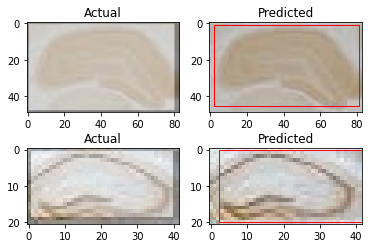

In [ ]:
# plot predictions for test dataset
plot_actual_vs_predicted(test, model, cfg)

The plot_actual_vs_predicted creates a figure showing two photos from the test data with the ground truth bounding boxes, with the same photo and the predicted bounding boxes alongside.

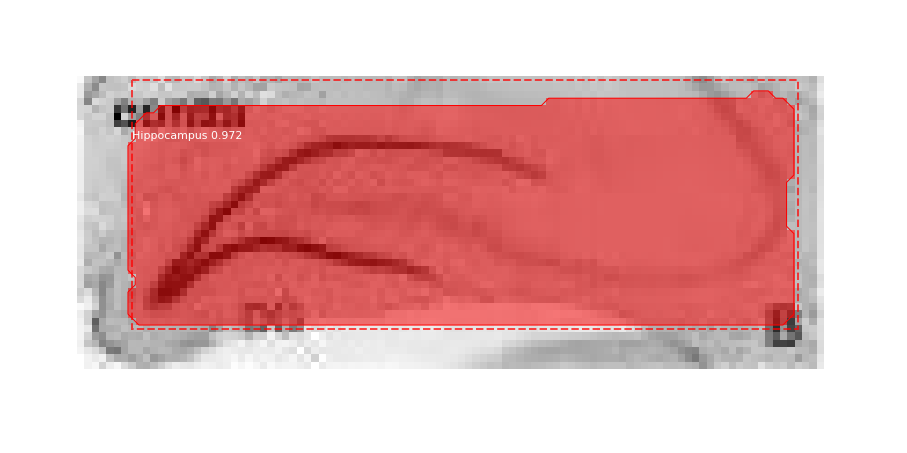

In [ ]:
from mrcnn.visualize import display_instances
# load photograph
img = load_img('/content/drive/MyDrive/images/images/test/9_2.jpg')
img = img_to_array(img)
# make prediction
results = model.detect([img], verbose=0)
# get dictionary for first prediction
r = results[0]
# show photo with bounding boxes, masks, class labels and scores
class_names = ['Background','Hippocampus']
display_instances(img, r['rois'], r['masks'], r['class_ids'], class_names, r['scores'])

The result shows the prediction of bounding box(dotted line) of the image along with object mask and prediction confidence(0.972)